# Coarse-graining Markov Chains with GT

We illustrate the tools avalable in the ``PyGT`` package for the dimensionality reduction of Markov chains using a model 32-state network. The network can be divided into 4 competing macrostates. We will compute the optimal $4 \times 4$ coarse-grained rate matrix with various numerical methods and compare the reduced dynamics to the original model.

In [3]:
#library code
import sys
sys.path.insert(0,"../")
import PyGT
#other modules
import numpy as np
import scipy.linalg as spla 
from scipy.sparse import issparse, diags
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Model 32-state network

Each community has 8 nodes, including 1 attractor node, 4 internal nodes, and 3 boundary nodes. Nodes are colored by the community to which they belong. Darker, larger nodes have higher equilbrium occupation probabilities, and thicker edges indicate slower transitions.

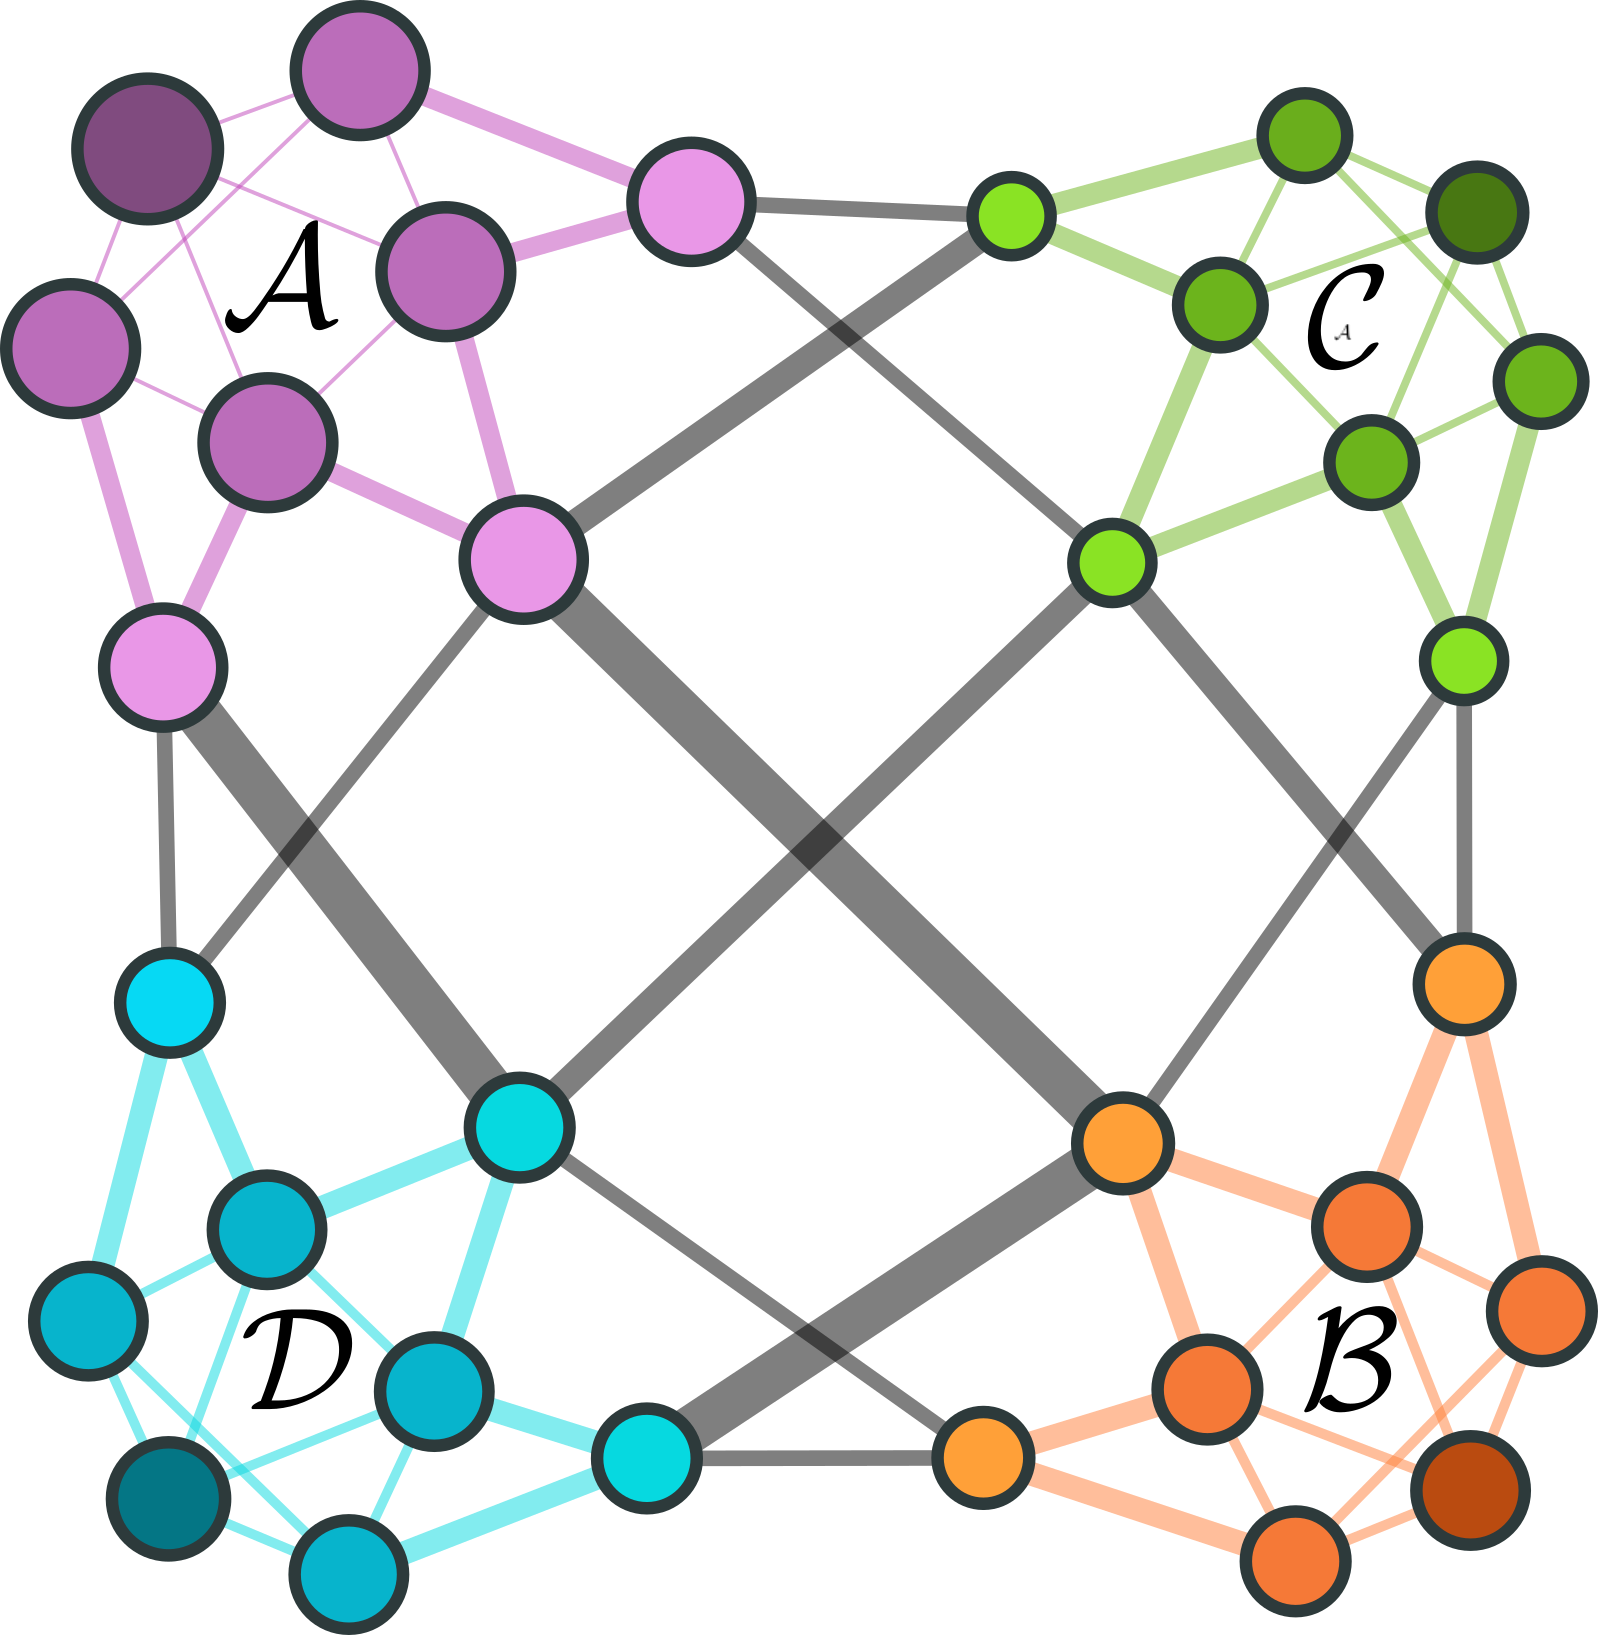

In [4]:
from IPython.display import Image
Image(filename = "32state.png", width = 300)

## GT setup

Let's load in the Markov chain as well as its community structure. Community assignments are specified in a single-column file where each line contains the community ID of the node corresponding to the line number.

In [5]:
data_path = Path('../KTN_data/32state')
temp = 10.0
beta = 1./temp
#GT setup
B, K, tau, N, u, s, Emin, retained = PyGT.io.load_ktn(path=data_path,beta=beta)
#rate matrix with columns that sum to zero
# K has no diagonal entries
if issparse(K):
    Q = K - diags(1.0/tau)
else:
    Q = K - np.diag(1.0/tau)

BF = beta*u-s
BF -= BF.min()
#stationary distribution
pi = np.exp(-BF)
pi /= pi.sum()
#A and B sets
AS,BS = PyGT.io.load_ktn_AB(data_path,retained) 
#Read in community structure
comms = PyGT.io.read_communities(data_path/'communities.dat', retained, screen=True)
for comm in comms:
    if np.all(comms[comm] == AS):
        print(f'Community A: {comm}')
    if np.all(comms[comm] == BS):
        print(f'Community B: {comm}')


Community 0: 8
Community 1: 8
Community 2: 8
Community 3: 8
Community A: 0
Community B: 3


## Matrix of inter-microstate MFPTs with GT vs. linear algebra methods

The $32 \times 32$ matrix of inter-microstate MFPTs between all pairs of nodes can be used to obtain the optimal reduced coarse-grained Markov chain for a given community structure. Let's compute this matrix with GT and with two alternative linear algebra methods: inversion to obtain the fundamental matrix and solving a linear equation.

In [6]:
#compute matrix of inter-microstate MFPTs with GT
mfpt_gt = PyGT.mfpt.full_MFPT_matrix(B, tau)

#check that the Kemeny constant is indeed constant
kemeny, success = PyGT.tools.check_kemeny(pi, mfpt_gt)
if success:
    print("Kemeny constant from mfpts with GT: ", kemeny)

#compute matrix of inter-microstate MFPTs with fundamental matrix
ktn = PyGT.tools.Analyze_KTN(data_path, K=Q.todense(), pi=pi, commdata='communities.dat')
mfpt_fund = ktn.get_intermicrostate_mfpts_fundamental_matrix()
kemeny_fund, success = PyGT.tools.check_kemeny(pi, mfpt_fund)
if success:
    print("Kemeny constant from mfpts with fundamental matrix: ", kemeny_fund)

#compute matrix of inter-microstate MFPTs by solving a linear equation
mfpt_lin = ktn.get_intermicrostate_mfpts_linear_solve()
kemeny_lin, success = PyGT.tools.check_kemeny(pi, mfpt_lin)
if success:
    print("Kemeny constant from mfpts with linear solve: ", kemeny_lin)


Kemeny constant from mfpts with GT:  97.53002029348983
Kemeny constant from mfpts with fundamental matrix:  97.53002029348986
Kemeny constant from mfpts with linear solve:  97.53002029348977


## Compute inter-community weighted-MFPTs

Defined as 
\begin{equation}
        [ \widetilde{{\mathcal{T}}}_\mathrm{C} ]_{IJ} =  \frac{1}{\Pi_I \Pi_J} \sum_{i \in I} \sum_{j \in J} \pi_i \mathcal{T}_{ij} \pi_j 
 - \frac{1}{\Pi_I \Pi_I} \sum_{i \in I} \sum_{i^\prime \in I} \pi_{i^\prime} \mathcal{T}_{i^\prime i} \pi_i.
\end{equation}

In [7]:
#compute weighted-MFPT between communities
commpi = ktn.get_comm_stat_probs(np.log(pi), log=False)
ktn.commpi = commpi
ncomms = len(commpi)
pt = ktn.get_intercommunity_weighted_MFPTs(mfpt_gt)
#Kemeny constant of reduced Markov chain
print("Weighted-MFPT matrix:")
print(pt)
c_kemeny, success = PyGT.tools.check_kemeny(commpi, pt)
if success:
    print('\nKemeny constant of coarse-grained Markov chain: ', c_kemeny)

Weighted-MFPT matrix:
[[ 0.         53.8206528  54.95852132 69.11554233]
 [53.00851035  0.         66.57240778 52.25954611]
 [54.71235842 67.13838734  0.         54.16914917]
 [69.93796797 53.8941142  55.2377377   0.        ]]

Kemeny constant of coarse-grained Markov chain:  44.06002077112634


## Different routes to obtain the optimal coarse-grained CTMC

In Kannan et al. *J. Chem. Phys.* (2020), we discuss three different expression for the optimal coarse-grained rate matrix given a partitioning of the $V$ nodes in the original Markov chain into $N$ communities: the HS relation, the KKRA relation, and an expression obtained from inverting the matrix of weighted-MFPTs. We illustrate the computation of all 3 methods below:

In [8]:
""" Three different version of the optimal reduced CTMC."""
#1) the original HS relation
K_hs = ktn.construct_coarse_rate_matrix_Hummer_Szabo()
#2) the KKRA relation involving inversion of matrix of inter-microstate mfpts
K_kkra = ktn.construct_coarse_rate_matrix_KKRA(GT=True)
#3) based on inversion of weighted-MFPTs
K_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))

print('Optimal reduced CTMC from Hummer-Szabo relation:')
print(K_hs)
print('Optimal reduced CTMC from KKRA relation:')
print(K_kkra)
print('Optimal reduced CTMC from inversion of weighted-MFPT matrix:')
print(K_invert)

#check that detailed balance is satisfied
if not PyGT.tools.check_detailed_balance(commpi, K_invert):
    print('Detailed balance not satisfied for K_C.')
if not PyGT.tools.check_detailed_balance(pi, Q):
    print('Detailed balance not satisfied for K')

Optimal reduced CTMC from Hummer-Szabo relation:
[[-0.05239043  0.02620963  0.02440272  0.0036629 ]
 [ 0.02493137 -0.05761829  0.00478585  0.02595583]
 [ 0.02390442  0.00492849 -0.05366994  0.0247118 ]
 [ 0.00355464  0.02648017  0.02448137 -0.05433052]]
Optimal reduced CTMC from KKRA relation:
[[-0.05239043  0.02620963  0.02440272  0.0036629 ]
 [ 0.02493137 -0.05761829  0.00478585  0.02595583]
 [ 0.02390442  0.00492849 -0.05366994  0.0247118 ]
 [ 0.00355464  0.02648017  0.02448137 -0.05433052]]
Optimal reduced CTMC from inversion of weighted-MFPT matrix:
[[-0.05239043  0.02620963  0.02440272  0.0036629 ]
 [ 0.02493137 -0.05761829  0.00478585  0.02595583]
 [ 0.02390442  0.00492849 -0.05366994  0.0247118 ]
 [ 0.00355464  0.02648017  0.02448137 -0.05433052]]


## Numerical comparison of coarse-grained Markov chains

To compare the numerical stability of these various routes to obtain the optimal reduced CTMC, let's compute the mean first passage times $\mathcal{A} \leftrightarrow \mathcal{B}$ on the original network and compare it to the corresponding observables on the various reduced networks.

In [9]:
def compare_HS_LEA(temps, data_path):
    """ Calculate coarse-grained rate matrices using the 3 versions of the optimal
    reudced Markov chain and the local equilibrium approximation (LEA).
    Compute MFPTAB/BA on the full and coarse-grained networks. """

    dfs = []
    for temp in temps:
        df = pd.DataFrame()
        df['T'] = [temp]
        #KTN input
        beta = 1./temp
        B, K, tau, N, u, s, Emin, retained = PyGT.io.load_ktn(path=data_path,beta=beta)
        Q = K - diags(1.0/tau)
        BF = beta*u-s
        BF -= BF.min()
        #stationary distribution
        pi = np.exp(-BF)
        pi /= pi.sum()
        #A and B sets
        AS,BS = PyGT.io.load_ktn_AB(data_path,retained) 
        #ktn setup
        ktn = PyGT.tools.Analyze_KTN(data_path, K=Q, pi=pi, commdata='communities.dat')
        ncomms = len(commpi)
        #MFPT calculations on full network
        full_df = PyGT.stats.compute_rates(AS, BS, B, tau, pi, fullGT=True, block=10)
        df['MFPTAB'] = full_df['MFPTAB']
        df['MFPTBA'] = full_df['MFPTBA']
        
        #compute coarse-grained networks
        mfpt = PyGT.mfpt.full_MFPT_matrix(B, tau)
        pt = ktn.get_intercommunity_weighted_MFPTs(mfpt)
        labels = []
        matrices = []
        try:
            Rhs = ktn.construct_coarse_rate_matrix_Hummer_Szabo()
            matrices.append(Rhs)
            labels.append('HS')
        except Exception as e:
            print(f'HS had the following error: {e}')
        try:
            Rhs_kkra = ktn.construct_coarse_rate_matrix_KKRA(mfpt=mfpt)
            matrices.append(Rhs_kkra)
            labels.append('KKRA')
        except Exception as e:
            print(f'KKRA had the following error: {e}')
        try:
            Rhs_invert = spla.inv(pt)@(np.diag(1./commpi) - np.ones((ncomms,ncomms)))
            matrices.append(Rhs_invert)
            labels.append('PTinvert_GT')
        except Exception as e:
            print(f'Inversion of weighted-MFPTs from GT had the following error: {e}')
        try:
            Rlea = ktn.construct_coarse_rate_matrix_LEA()
            matrices.append(Rlea)
            labels.append('LEA')
        except Exception as e:
            print(f'LEA had the following error: {e}')

        if len(matrices)==0:
            continue

        for i, R in enumerate(matrices):
            """ get A->B and B->A mfpt on coarse network"""
            rK = R - np.diag(np.diag(R))
            escape_rates = -1*np.diag(R)
            B = rK@np.diag(1./escape_rates)
            tau = 1./escape_rates
            #B, tau = PyGT.tools.load_CTMC(R)
            Acomm = 0
            Bcomm = 3
            MFPTAB, MFPTBA = PyGT.mfpt.compute_MFPT(Acomm, Bcomm, B, tau, block=10)
            df[f'AB_{labels[i]}'] = [MFPTAB]
            df[f'BA_{labels[i]}'] = [MFPTBA]
        dfs.append(df)
    bigdf = pd.concat(dfs, ignore_index=True, sort=False)
    return bigdf

In [15]:
#some high temperature calculations
invtemps = np.linspace(0.1, 4, 10)
hightemp_df = compare_HS_LEA(1./invtemps, data_path)

In [10]:
def plot_mfpts_32state(df):
    """Plot MFPTs computed on coarse-grained networks against true MFPT from full network."""
    colors = sns.color_palette("Dark2", 4)
    df.replace([np.inf, -np.inf], np.nan)
    df2= df.sort_values('T')
    symbols = ['-s', '--o', '-o', '--^']
    rates = ['LEA', 'PTinvert_GT', 'KKRA', 'HS']
    labels = rates
    denom = 'MFPT'
    #first plot A<-B direction
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=[10, 4])
    ax.plot(1./df2['T'], df2['MFPTBA'], '-', color='k', label='Exact', lw=1, markersize=4)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'BA_{CG}'].isna()]
        ax.plot(1./df2CG['T'], df2CG[f'BA_{CG}'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax.set_xlabel(r'$1/T$')
    ax.set_yscale('log')
    ax.set_ylabel('MFPTBA')
    ax.legend(frameon=True)
    ax2.plot(1./df2['T'], df2['MFPTAB'], '-', color='k', label='Exact', lw=1, markersize=4)
    for j, CG in enumerate(rates):
        #then only plot HSK for temperatures that are not NaN
        df2CG = df2[-df2[f'AB_{CG}'].isna()]
        ax2.plot(1./df2CG['T'], df2CG[f'AB_{CG}'],
                symbols[j], label=labels[j], color=colors[j], linewidth=1,
                markersize=4)
    ax2.set_xlabel(r'$1/T$')
    ax2.set_ylabel('MFPTAB')
    ax2.set_yscale('log')
    ax2.legend(frameon=True)
    fig.tight_layout()

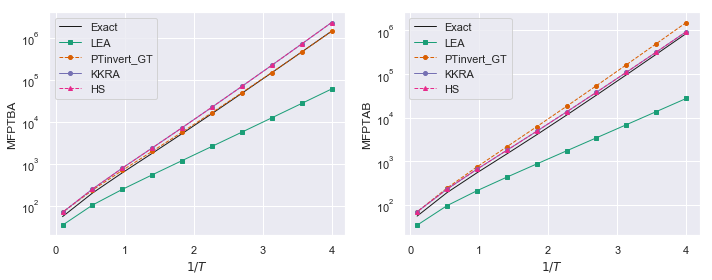

In [16]:
plot_mfpts_32state(midtemp_df)

The three methods to obtain the optimal reduced Markov chain (HS, KKRA, and the inversion of the weighted-MFPT matrix computed with GT) produce similar MFPTs that are close to the exact value calculated on the original Markov chain. The LEA is significantly less accurate in comparison, because it only takes into account transitions between the boundary nodes of $\mathcal{A}$ and $\mathcal{B}$. Since some transitions within each community are on a similar timescale to the fastest inter-community edges, our model network lacks the drastic separation of timescales required for the LEA assumption to hold. Thus, more advanced methods to estimate inter-community rates are required.

In [17]:
invtemps = np.linspace(0.1, 20, 10)
lowtemp_df = compare_HS_LEA(1./invtemps, data_path)

HS does not satisfy detailed balance


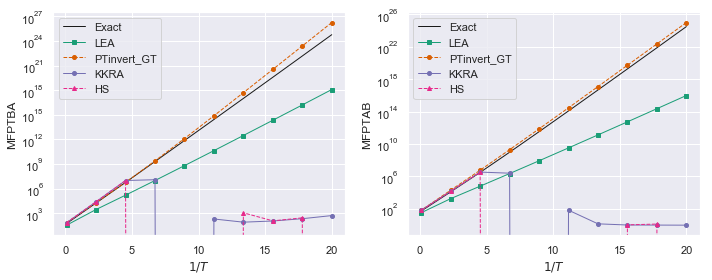

In [18]:
plot_mfpts_32state(lowtemp_df)

At low temperatures ($1/T > 5$), the original HS and KKRA relations become numerically unstable because they require the inversion of ill-conditioned matrices. The weighted-MFPT matrix is comparatively well-conditioned, so the inversion of this matrix to obtain the optimal reduced CTMC remains a numerically stable calculation down to temperatures as low as $1/T \approx 150$. Graph transformation thus provides unique access to optimal Markovian coarse-graining in the metastable regime.